# Text retrival
You can take a lot of text and pass it to an LLM as context. We know though that filling the context window is not a good idea - you get wonky outputs. So this notebook implements some tools to get text features and extract information from text files. In this case we are going to experiment with pulling passages based on character intercations from *Crime and Punishment* by Fyodor Dostoevsky. We'll say that any time two characters names are mentioned within *N* sentences of eachother, that they had an interaction. Now that's a simple but not necessarily the most correct way of doing this. We also would need some text classifiers to relate the characters to more abstract concepts they represent in order for the llm to be exposed to some types of metaphors and symbolism. But ok, this is a first pass on this topic.


In [19]:
# we will need this for graphs later
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.7 MB/s eta 0:00:00


In [1]:
# this gives access to your whole drive and google account
# dont put anything in here that youre not using to code
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
import os
import re
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyvis.network import Network
from IPython.display import HTML

In [3]:
# funciton to get text
def GetText(x):
    with open(x, "r" ) as f:
        return f.read()

In [4]:
Book = '/content/drive/My Drive/Books/crime and punishment.txt'
text = GetText(Book)

In [5]:
def GetCharacters(text):
    # get Unique characters
    chars = sorted(list(set(text)))
    letters = sorted([c for c in chars  if c.isalpha()])
    special_chars = "".join(sorted(list(set(chars) - set(letters))))
    return chars, special_chars

chars, special_chars = GetCharacters(text)
# here's a string containing all the special charcters
print(special_chars)

# print them as a list to see new line chars and spaces
print(list(special_chars))




 !#$%()*,-./0123456789:;?[]_—‘’“”•™﻿
['\n', ' ', '!', '#', '$', '%', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', '_', '—', '‘', '’', '“', '”', '•', '™', '\ufeff']


You can pretty much grab everything we want to grab from the text with really regular expressions. This saves us the trouble of having to write a state machine, and looking out for patterns as the code itterates over characters. Now id you want something a lot faster, then you do exactly that.


In [6]:
# all the paragraphs in this text sample are after double new line characters
def GetParagraphs(text):
    # get all the paragraph indices.
    paragraph_inds = [0]
    for match in re.finditer(r'\n\n',text):
        paragraph_inds.append(match.start())

    paragraphs = []
    for pi in range(len(paragraph_inds)-1):
        paragraphs.append((text[paragraph_inds[pi]+2:paragraph_inds[pi+1]]))

    return paragraph_inds, paragraphs

paragraph_inds, paragraphs = GetParagraphs(text)

print(paragraphs[43].replace('\n', ' '))

“If I am so scared now, what would it be if it somehow came to pass that I were really going to do it?” he could not help asking himself as he reached the fourth storey. There his progress was barred by some porters who were engaged in moving furniture out of a flat. He knew that the flat had been occupied by a German clerk in the civil service, and his family. This German was moving out then, and so the fourth floor on this staircase would be untenanted except by the old woman. “That’s a good thing anyway,” he thought to himself, as he rang the bell of the old woman’s flat. The bell gave a faint tinkle as though it were made of tin and not of copper. The little flats in such houses always have bells that ring like that. He had forgotten the note of that bell, and now its peculiar tinkle seemed to remind him of something and to bring it clearly before him.... He started, his nerves were terribly overstrained by now. In a little while, the door was opened a tiny crack: the old woman eye

We have paragraphs, so now lets get the quoted text.


In [7]:
def GetBoundText(text, open_, close_):
    ''' Variant of get paragraphs find all matches between double quotes
    Escape in case delimiters are regex special chars'''
    open_esc = re.escape(open_)
    close_esc = re.escape(close_)

    pattern = f"{open_esc}(.*?){close_esc}"
    matches = list(re.finditer(pattern, text, flags=re.S))

    bound_inds = []
    bound_texts = []

    for m in matches:
        bound_inds.append(m.start())
        clean_quote = m.group(1).replace('\n', ' ')
        bound_texts.append(clean_quote)  # inside the delimiters

    return bound_inds, bound_texts

# quotes are defined by special charcters in this text
quoted_inds, quoted_texts = GetBoundText(text,
                                        open_ = special_chars[-5],
                                        close_ = special_chars[-4])
for qtext in quoted_texts[100:150]:
    print('...')
    print(qtext)


...
Let us go, sir,
...
come along with me... Kozel’s house, looking into the yard. I’m going to Katerina Ivanovna--time I did.
...
It’s not Katerina Ivanovna I am afraid of now,
...
and that she will begin pulling my hair. What does my hair matter! Bother my hair! That’s what I say! Indeed it will be better if she does begin pulling it, that’s not what I am afraid of... it’s her eyes I am afraid of... yes, her eyes... the red on her cheeks, too, frightens me... and her breathing too.... Have you noticed how people in that disease breathe... when they are excited? I am frightened of the children’s crying, too.... For if Sonia has not taken them food... I don’t know what’s happened! I don’t know! But blows I am not afraid of.... Know, sir, that such blows are not a pain to me, but even an enjoyment. In fact I can’t get on without it.... It’s better so. Let her strike me, it relieves her heart... it’s better so... There is the house. The house of Kozel, the cabinet-maker... a German, wel

Ok now lets get all the sentences directly from the text the same way we did the paragraphs.

In [8]:
def GetSentences(text, offset = 0):
    '''Given any text input get any character followed by a group of
    chatacters till you get to a terminating puncuation.'''
    text = text.replace('\n',' ')
    pattern = r".+?[.?!](?=\s)"
    matches = re.finditer(pattern, text)

    sentence_starts = []
    sentence_ends = []
    sentences = []
    for m in matches:
        start_ = m.start()+offset
        stop_ = m.end()+offset
        sentence_starts.append(start_)
        sentence_ends.append(stop_)
        sent = f"'{m.group()}' [{start_}:{stop_}]"
        sentences.append(m.group())
        # print(sent)

    return sentence_starts, sentence_ends, sentences

a0, a1, sentences_00 = GetSentences(text)
for si, sent in enumerate(sentences_00[100:150]):
    print('---')
    print(f'sentence {si+100} [{a0[si+100]}:{a1[si+100]}] ', sent)



---
sentence 100 [11889:12036]    With a sinking heart and a nervous tremor, he went up to a huge house which on one side looked on to the canal, and on the other into the street.
---
sentence 101 [12036:12238]   This house was let out in tiny tenements and was inhabited by working people of all kinds--tailors, locksmiths, cooks, Germans of sorts, girls picking up a living as best they could, petty clerks, etc.
---
sentence 102 [12238:12339]   There was a continual coming and going through the two gates and in the two courtyards of the house.
---
sentence 103 [12339:12397]   Three or four door-keepers were employed on the building.
---
sentence 104 [12397:12530]   The young man was very glad to meet none of them, and at once slipped unnoticed through the door on the right, and up the staircase.
---
sentence 105 [12530:12736]   It was a back staircase, dark and narrow, but he was familiar with it already, and knew his way, and he liked all these surroundings: in such darkness even the m

An alternative way to get all the sentences is to itterate through all the paragraphs and apply the GetSentences funciton. This one keeps offsets, so here we can associate any paragraph with any sentence pretty easily. Although we have all the character indices for the sentences up above any way, so this is just some redundancy.



In [9]:
def GetSentencesFromParagraphs(paragraphs, paragraph_inds):
    # Get all the sentences in paragraphs
    sentence_starts = []
    sentence_ends = []
    sentences = []
    for para, pis in zip(paragraphs, paragraph_inds):
        a,b,c = GetSentences(para, offset = pis)
        sentence_starts.extend(a)
        sentence_ends.extend(b)
        sentences.extend(c)

    return sentence_starts, sentence_ends, sentences

sentence_starts, sentence_ends, sentences = GetSentencesFromParagraphs(paragraphs, paragraph_inds)

for si, sent in enumerate(sentences[100:150]):
    print('---')
    print(f'sentence {si+100} [{sentence_starts[si+100]}:{sentence_ends[si+100]}] ', sent)


---
sentence 100 [14047:14121]   The old woman stood facing him in silence and looking inquiringly at him.
---
sentence 101 [14121:14226]   She was a diminutive, withered up old woman of sixty, with sharp malignant eyes and a sharp little nose.
---
sentence 102 [14226:14329]   Her colourless, somewhat grizzled hair was thickly smeared with oil, and she wore no kerchief over it.
---
sentence 103 [14329:14524]   Round her thin long neck, which looked like a hen’s leg, was knotted some sort of flannel rag, and, in spite of the heat, there hung flapping on her shoulders, a mangy fur cape, yellow with age.
---
sentence 104 [14524:14576]   The old woman coughed and groaned at every instant.
---
sentence 105 [14996:15008]  “And here...
---
sentence 106 [15008:15128]   I am again on the same errand,” Raskolnikov continued, a little disconcerted and surprised at the old woman’s mistrust.
---
sentence 107 [15621:15848]  “So the sun will shine like this _then_ too!” flashed as it were by chance t

There's an offset in the sentence number but not the character index.

*Scanning directly from the text*

sentence 118 [14049:14123]   The old woman stood facing him in silence and looking inquiringly at him.

*Scanning from the paragraph list*

sentence 100 [14047:14121]   The old woman stood facing him in silence and looking inquiringly at him.

2 character offset --> The paragraph retriever splits on double new line characters. so that would do it.


---
ok so the next part we want to start looking for relationships within the text. Lets start with full names. So look for any words where there's 2 consecutive words capitalized. That will give words at the start of the sentence, but also usually full names. Better logic = better features = better retrieval.

In [10]:
def GetDoubleCaps(text):
    text = text.replace('\n', ' ')
    # trying to find names here
    pattern = r"\b[A-Z][a-z]+\s+[A-Z][a-z]+\b"
    matches = list(re.finditer(pattern, text))

    start_inds =[]
    end_inds = []
    objs = []
    for m in matches:
        objs.append(m.group())
        start_inds.append(m.start())
        end_inds.append(m.end())
    return start_inds, end_inds, objs

# get names of characters and what not. might hard code these.
DoubleCapped_starts, DoubleCapped_ends, DoubleCapped_ = GetDoubleCaps(text)
print(sorted(list(set(DoubleCapped_))))

['About Project', 'Afanasy Ivanitch', 'Afanasy Ivanovitch', 'Afanasy Pavlovitch', 'After It', 'After Nikolay', 'Again Dounia', 'Again Sonia', 'Alexandr Grigorievitch', 'Alexey Semyonovitch', 'Although Pulcheria', 'Alyona Ivanovna', 'Amalia Fyodorovna', 'Amalia Ivanovna', 'Amalia Lippevechsel', 'Amalia Ludwigovna', 'An Hussar', 'And Avdotya', 'And Darya', 'And Dmitri', 'And Dounia', 'And He', 'And Jesus', 'And Karl', 'And Katerina', 'And Luzhin', 'And Marfa', 'And Mikolka', 'And Mitka', 'And Nastasya', 'And Nikodim', 'And Porfiry', 'And Pyotr', 'And Razumihin', 'And Sonia', 'And Thy', 'Andrey Semyonovitch', 'Archive Foundation', 'Arkady Ivanovitch', 'Asia Minor', 'Ask Kapernaumov', 'At Sonia', 'Avdotya Romanovna', 'Ave Maria', 'Before Sonia', 'Better Porfiry', 'But Avdotya', 'But Dounia', 'But Katerina', 'But Luzhin', 'But Mr', 'But Nikolay', 'But Porfiry', 'But Pulcheria', 'But Pyotr', 'But Raskolnikov', 'But Sonia', 'By Constance', 'By Fyodor', 'By Jove', 'Constance Garnett', 'Darya F

Cool so we have a lot of words in here that are not actually players in the book. so we have to filter it.

In [11]:
# heres a function to get a count of all the words
def GetWordCounts(X):
    X_counts = {}
    for x in X:
        if not x in X_counts.keys():
            X_counts[x] = 1
        else:
            X_counts[x]+=1
    return X_counts

# So here given all the double capped words, we can filter out into the likely
# characters/ players in the book.
def GetLikelyPlayers(DoubleCapped_):
    # Get the individual words
    DC_2 = []
    for dc in DoubleCapped_:
        DC_2.extend(dc.split())

    DC_2_counts = GetWordCounts(DC_2)
    sorted_items_descending = sorted(DC_2_counts.items(), key=lambda item: item[1], reverse=True)
    print(sorted_items_descending)

    # filter this so you dont get an unmanageable amount of word pairs
    thresh = 15
    common = ['Project','Gutenberg', 'The', 'But', 'And']
    DC_2_counts['Marmeladov']+=20 # I know marmeladov is a character in here
    top_DC_2 = {k:v for k,v in DC_2_counts.items() if v>thresh and not any([k== c for c in common])}

    # then this part is just for printing
    sorted_items_descending = sorted(top_DC_2.items(), key=lambda item: item[1], reverse=True)
    print(sorted_items_descending)

    # getting back a dictionary of the top players + their counts
    return top_DC_2

LikelyPlayers = GetLikelyPlayers(DoubleCapped_)

[('Ivanovna', 291), ('Petrovitch', 278), ('Katerina', 216), ('Pyotr', 173), ('Pulcheria', 123), ('Alexandrovna', 117), ('Avdotya', 115), ('Romanovna', 107), ('Porfiry', 91), ('Rodion', 88), ('Romanovitch', 86), ('Project', 84), ('Gutenberg', 79), ('Marfa', 78), ('Sofya', 75), ('Petrovna', 73), ('Semyonovna', 70), ('Amalia', 68), ('God', 40), ('And', 37), ('Ilya', 33), ('Dmitri', 25), ('Nikodim', 24), ('Semyonovitch', 24), ('Prokofitch', 24), ('Good', 23), ('But', 22), ('Fomitch', 22), ('Andrey', 21), ('Hay', 20), ('Market', 20), ('Raskolnikov', 19), ('Ivanovitch', 18), ('United', 16), ('States', 16), ('Alyona', 16), ('Sonia', 16), ('The', 15), ('Madame', 14), ('Literary', 13), ('Archive', 13), ('Semyon', 12), ('Arkady', 11), ('Zaharovitch', 10), ('Praskovya', 9), ('Pavlovna', 9), ('When', 9), ('Dounia', 9), ('My', 9), ('Thank', 8), ('Afanasy', 8), ('Razumihin', 8), ('Luise', 8), ('Resslich', 8), ('Lippevechsel', 7), ('Lizaveta', 7), ('Then', 7), ('Ludwigovna', 7), ('Though', 7), ('Foun

In [12]:
def GetImportantPairs(LikelyPlayers):
    # take all the players from the dict and make pairs
    npDC_2 = np.array(list(LikelyPlayers.keys())) # source nodes

    # number of players
    n = len(npDC_2)

    # Pairing players makes a square matrix - O(N^2) scaling so filter likely players
    i, j = np.meshgrid(np.arange(n), np.arange(n), indexing="ij")
    mask0 = i<j
    pairs = np.column_stack((npDC_2[i[mask0]], npDC_2[j[mask0]])) # branches
    pairs_counts = np.zeros((pairs.shape[0],))
    print('pairs shape ', pairs.shape, n)
    print('node -> to -> node \n', pairs[0:10])
    print('node names \n', npDC_2)
    # return the resulting player list, and the pairs
    return npDC_2, pairs, pairs_counts

# Get important pairs -- consider this node-to-node.
node_list, pairs, pairs_counts = GetImportantPairs(LikelyPlayers)

pairs shape  (561, 2) 34
node -> to -> node 
 [['United' 'States']
 ['United' 'Hay']
 ['United' 'Market']
 ['United' 'Alyona']
 ['United' 'Ivanovna']
 ['United' 'Marmeladov']
 ['United' 'Katerina']
 ['United' 'Amalia']
 ['United' 'Sofya']
 ['United' 'Semyonovna']]
node names 
 ['United' 'States' 'Hay' 'Market' 'Alyona' 'Ivanovna' 'Marmeladov'
 'Katerina' 'Amalia' 'Sofya' 'Semyonovna' 'Sonia' 'Ivanovitch' 'God'
 'Marfa' 'Petrovna' 'Pyotr' 'Petrovitch' 'Avdotya' 'Romanovna' 'Rodion'
 'Romanovitch' 'Good' 'Raskolnikov' 'Ilya' 'Nikodim' 'Fomitch'
 'Semyonovitch' 'Porfiry' 'Dmitri' 'Andrey' 'Pulcheria' 'Alexandrovna'
 'Prokofitch']


In [13]:
def CleanSpecialChars(text: str) -> str:
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()
# why use numpy like this? you might ask -- well it's because we want some pagentry
# also numpy is built on C. So if I want to make a lot of comparisons, I should
# use numpy instead of python's built in funcitons. I'm basically making numpy
# call C code that runs way faster, but adding in complexity to the code.
def word_to_int(words):
    '''use this to convert words to integers in numpy
    quick text matcher through multiplication -- check for perfect squares'''
    return np.array([abs(hash(w.lower())) % 10_000_019 for w in words])

def perfect_square_matches(arr1, arr2):
    '''Compare two arrays of words elementwise.
    Return a boolean mask where matches form perfect squares'''
    a = np.array([word_to_int(w) for w in arr1])
    b = np.array([word_to_int(w) for w in arr2])

    products = a * b
    sqrt = np.sqrt(products)
    return np.isclose(sqrt, np.round(sqrt))

def DoSomething(node_list, pairs, sentences, sentence_window = 10):
    running_char_set = []

    for sii in range(0,len(sentences)-sentence_window, sentence_window):
        sents_ = ' '.join(sentences[sii: sii + sentence_window])
        print(sents_)
        # so the next thing thats going to happen is you're going to
        # search through all the sentences... If say the first word
        # in the word pair isnt in there, then you can skip over the entire branch man.
        # ok..... hm. So you if you itterate over npDC_2 thats the source node
        # you can make sub sets out of the pairs.....
        clean_sent = CleanSpecialChars(sents_, ).split() # make sure this ends up as a list
        print('clean sentence', clean_sent)

        # Check to see if the nodes from the node list occur together in pairs within the sentence window
        clean_sent_word_hash = word_to_int(clean_sent)
        print('sentence word hash :', clean_sent_word_hash)
        for node in node_list:
            # so what you do is itterate through the source nodes
            # check it if is in the sentence
            if node in clean_sent:
                mask = node == pairs[:,0]
                sub_nodes = pairs[mask]
                sub_nodes_inds = np.where(mask)[0]
                print(node, sub_nodes)

                # Now you want a way to go through the second column and see what word is there
                # if they were numbers I'd multiply and look for perfect squares.
                sub_nodes_hash = word_to_int(list(sub_nodes[:,1]))
                print(sub_nodes_hash)

                # use int 64
                opp = np.array(sub_nodes_hash, dtype=np.int64)[...,np.newaxis] * np.array(clean_sent_word_hash, dtype=np.int64)[np.newaxis,...]
                sqrt_opp = np.floor(np.sqrt(opp)).astype(np.int64)
                condition50 = sqrt_opp*sqrt_opp == opp
                sub_node_idx = np.where(condition50)[0]
                # check for perfect quare
                print(condition50)
                print(sub_node_idx)

                # Map back into global indices
                global_idx = sub_nodes_inds[sub_node_idx]

                # Increment counts
                pairs_counts[global_idx] += 1 / sentence_window
                # if you save the data frames over time..... then you get a full object that tells you how the relationships evolve over time.
                running_char_set.append(0+pairs_counts[...,np.newaxis])

    print("pair_counts :", pairs_counts)
    full_pairs_data= np.concatenate([pairs, pairs_counts[...,np.newaxis]], axis= -1)
    print(full_pairs_data)
    pd_full_pairs_data = pd.DataFrame(full_pairs_data, columns = ['x0','x1', 'counts'])
    pd_full_pairs_data['counts'] = pd_full_pairs_data['counts'].astype(float)
    pd_full_pairs_data = pd_full_pairs_data.sort_values(by="counts", ascending=False)
    pd_full_pairs_data.to_csv(f'pair counts {sentence_window} sentence.csv')

    # concatenate for now
    running_char_set = np.concatenate(running_char_set, axis = -1)


    return running_char_set, pd_full_pairs_data

running_char_set, pd_full_pairs_data = DoSomething(node_list, pairs, sentences, sentence_window = 10)

Streaming output truncated to the last 5000 lines.
 3014958 7792912 4516502 2810861 7385967 6813730  812245 9228599 5566828
 7649699 6620007  230796 7792912 3014958 5056415 7716713 3694924 7592672
 6682825 6088509 4848313 6329728 1530548  230796 7792912 6266072 1534706
 5669234 9769003  230796 3998849 2448509  230796 3998849 2448509  230796
 3998849 7462603 6408344 5076442 1194633 5988580 4625168 5082631  230796
 3998849 7462603 6408344  632647  312485 4848313 1962064 4993143 4872079
 6682825 9089084 3453126 6769255 2087865 6329728 2711878 3815247 1962064
 1534706 5400669 6682825 1534706 5669234 4848313 8305940 6682825  726480
 8413380 7927802 3356544 5266337 8312464 4872079 8778095 5988580 8364715
 6682825 6408344 5220196 5200896 4848262 6303867 5486502 5071756 9659204
 2671139 4872079 6228352 9812826 7462603  665617 2448509 6557427 8880542
 4872079  758434  230796 9659204 6557427 5200896 5261712 3694924 8366509
 3815247 1962064 2944472 5261712 9812826 6656900 6682825 7017714 3532771


Quick side note. Now that we are thinking in terms of hashing and what not. I bet there's some utility in hashing / embedding words and making lookupt tables between the resulting vectors and the word, so that you dont have to one hot encode the whole words set. So like with character prediction you're only looking at generating 1 char at a time, and that's nice because you don't have a whole lot of characters. For words though? There's a list of like 157,000 most commonly used english words. So 2^17 = 131,012 --> do 2^18 and now you can represent 262,144 words with 18 bits. right. its the difference between an output from your transformer that is 262,144 or 18.

See https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/English/Wikipedia_(2016)

Check on the pairs data and how many times those pairs come up within the defined sentence windows.

In [20]:
pd_full_pairs_data

,x0,x1,counts
156,Ivanovna,Katerina,8.6
408,Pyotr,Petrovitch,6.9
441,Avdotya,Romanovna,6.0
470,Rodion,Romanovitch,5.6
319,Sonia,Raskolnikov,5.4
...,...,...,...
11,United,Ivanovitch,0.0
10,United,Sonia,0.0
9,United,Semyonovna,0.0
8,United,Sofya,0.0


Ok but now we want to visualize these relationships. We already have x0 -> to ->x1 as the directed edges in a graph. the counts are the edge weights. so we can use pyvis and HTML to view it. The graph below is interactive so just click on nodes and move it around if you have trouble seeing any relationships.

In [34]:
def graphmaker(data_):
  net = Network(notebook=True, directed = True, cdn_resources='in_line')
  thresh = 0.5 # the lower the threshold, the more nodes connect, but the more the thing looks like a ball.
  for _, row in data_.iterrows():
    if row['counts']>thresh:
      net.add_node(row['x0'], label=row['x0'], font={"size": 30})
      net.add_node(row['x1'], label=row['x1'], font={"size": 30})
      net.add_edge(row['x0'], row['x1'], value=row['counts'])  # 'value' controls edge thickness

  net.force_atlas_2based()  # nice force-directed layout
  net.show("graph.html")
graphmaker(pd_full_pairs_data)

HTML(filename="graph.html")

graph.html


So the relationships will only be as good as the text retrieval system that we implemented. Here there's no connection betweeen Raskolnikov and his "best friend" Dmitri Rhazhumikin. Personally I'm gonna take it as Raskolnikov not being all that good a friend to Dmitri. Raskolnikov goes and visits Dmitri at one point, and Dmitri keeps checking in on Raskolnikov and his family at various points in the book.. so you'd imagine he'd show up more in this thing.  

Now that we understand the pairwise stuff, we want to know some useful information. A Priori - we hapen to know that Raskolnikov is the main character and committs a crime pretty early on in the book. We know that his love interest is Sonia. She tends to push him to religion and salvation in their interactions. Porfiry is the crime investigator. So we should plot out points where these pairs of characters meet

rcs index :  510


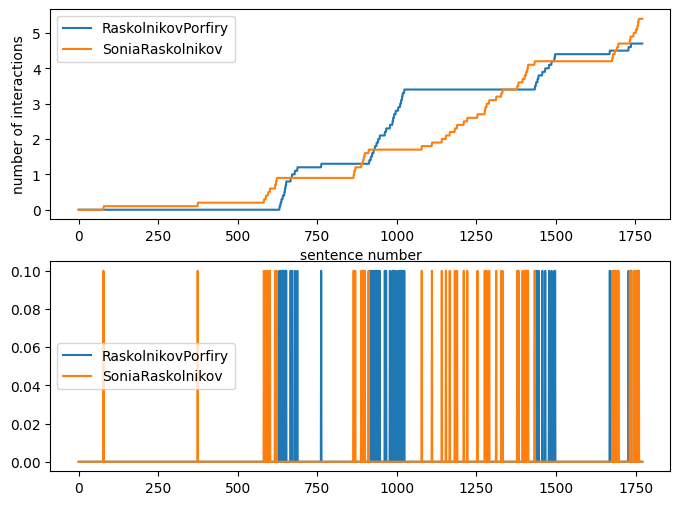

In [15]:
# get a top relationship
rcs_index = np.where(pairs[:,0]+pairs[:,1] == 'RaskolnikovPorfiry')[0][0]
rcs_index2 =np.where(pairs[:,0]+pairs[:,1] == 'SoniaRaskolnikov')[0][0]
print('rcs index : ', rcs_index)

# this could be a function too.
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(running_char_set[rcs_index, :], label = 'RaskolnikovPorfiry')
axes[0].plot(running_char_set[rcs_index2, :], label = 'SoniaRaskolnikov')
axes[0].set_ylabel('number of interactions')
axes[0].set_xlabel('sentence number')
axes[0].legend()

axes[1].plot(np.diff(running_char_set[rcs_index, :]), label = 'RaskolnikovPorfiry')
axes[1].plot(np.diff(running_char_set[rcs_index2, :]), label = 'SoniaRaskolnikov')
axes[1].legend()
plt.show()
# plt.savefig(f'relationships_{sentence_window}sentence.png')

So you can see that everytime raskolnikov interacts with sonia, he basically goes and interacts with Porfiry next. So now we want to text out passing specific sentences rather than the whole text to an llm and seeing if there's any kind of difference in the output. but we will get to that.




---
Ok now what if I want a feature based on when new words are introduced into the book? So thats this next section

In [16]:
# this is a function for getting the occurence of new words
def GetWordsAndInds(text, special_chars = '.'):
    pattern = "[" + re.escape(special_chars) + "]"
    # replace the special character with a space
    f_text = re.sub(pattern, " ", text)

    # now you have every word in order of occurence
    words = f_text.split()
    total_n_words = len(words)
    uwords = set()
    uwords_and_locs = []
    for wi, word_ in enumerate(words):
        # now you have an index and each word
        # I want to know that it is alpha numeric
        filtered_word = ''.join([fw_ for fw_ in word_.lower() if fw_.isalpha()])
        if not filtered_word in uwords:
            uwords.add(filtered_word)
            uwords_and_locs.append([filtered_word,wi])
    return uwords_and_locs, total_n_words
# use this to get the location where all the unique words occur
uwords_and_locs, total_n_words = GetWordsAndInds(text, special_chars = special_chars)

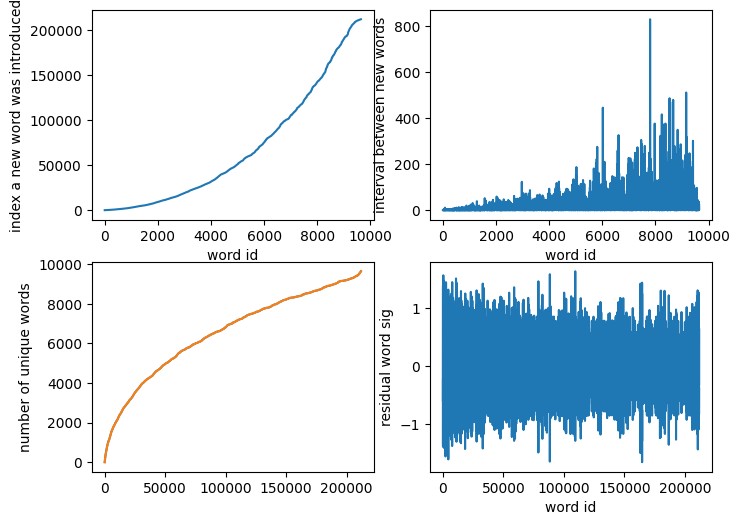

In [17]:
def plot_word_signals(tot_n_words, words_and_inds):

    ## Word Signals
    # ok so now if I want to get the character index where the new thing occured
    new_word_inds = np.array([bd[1] for bd in words_and_inds])
    word_signal = np.ones((tot_n_words,))
    for ind_ in new_word_inds:
        word_signal[ind_::]+=1

    # this feature is a bit more expensive to capture.
    filt_word_signal = scipy.signal.savgol_filter(word_signal, 31, 2)
    residual_word_sig = word_signal-filt_word_signal
    # it does spike up and down a lot, and the 0 crossings should tell you something. but idk yet
    # plotting
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    axes[0,0].plot(new_word_inds)
    axes[0,0].set_ylabel('index a new word was introduced')
    axes[0,0].set_xlabel('word id')

    # this interval will be longer toward the end -- you care about spikes
    # from the base line -- it should mean something when the inteval spikes or drops
    # for some reason -- that difference should give you like a normalized version of the
    # interval between words signal. More words should mean the speaker is introducing a new concept
    # less words means the speaker is either elaborating or in a lull.


    axes[0,1].plot(np.diff(new_word_inds))
    axes[0,1].set_ylabel('interval between new words')
    axes[0,1].set_xlabel('word id')

    axes[1,0].plot(word_signal)
    axes[1,0].plot(filt_word_signal)

    axes[1,0].set_ylabel('number of unique words')

    # # this should be 1s and 0s so not meaningful...
    # axes[1,1].plot(np.diff(word_signal))
    # axes[1,1].set_ylabel('diff number of unique words')

    # this should be 1s and 0s so not meaningful...
    # axes[1,1].plot(np.diff(new_word_inds) / book_dat['Tn_words'])
    axes[1,1].plot(residual_word_sig)
    axes[1,1].set_ylabel('residual word sig')
    axes[1,1].set_xlabel('word id')
    plt.show()
plot_word_signals(total_n_words, uwords_and_locs)

First plot is the index of when new words are introduced. The next plot is the interval between new words. You care about spikes in intervals between new words because if there are a bunch of new words being added into the vocabulary rapidly it's likely to mean that there is a new concept being introduced, or a new character, or something important. Lower amounts of words, are likely to be ellaboration and explanation.

